In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder

In [2]:
data = pd.read_csv('../data/data.csv')
data.head()

,state,year,total_pop,white_pop,black_pop,hispanic_pop,asian_pop,native_pop,islander_pop,multi_race_pop,...,crimes_against_society,fraud_and_other_financial_crimes,property_crime,violent_crime,youth_not_in_school,youth_in_foster_care,youth_living_in_poverty,total_crime_count,log_total_crime_count,youth_school_poverty_interaction
0,AL,2022,4916000,0.645,0.252,0.0480,0.0140,0.002,0.0,0.039,...,4804.0,913.5,6430.5,7584.5,73000.0,819.25,240000.000000,19732.5,9.890073,1.752000e+10
1,AL,2021,4900800,0.644,0.255,0.0470,0.0130,0.004,0.0,0.037,...,3236.5,618.0,5552.0,5527.5,86000.0,819.25,245000.000000,14934.0,9.611463,2.107000e+10
2,AL,2020,4833950,0.649,0.260,0.0455,0.0135,0.004,0.0,0.028,...,327.0,45.0,325.0,419.5,82000.0,819.25,249833.333333,1116.5,7.018849,2.048633e+10
3,AL,2019,4767100,0.654,0.265,0.0440,0.0140,0.004,0.0,0.019,...,94.0,30.5,171.0,108.5,74000.0,800.00,228000.000000,404.0,6.003887,1.687200e+10
4,AL,2018,4752600,0.656,0.265,0.0430,0.0130,0.010,0.0,0.019,...,33.0,15.5,37.0,52.5,86000.0,829.00,255000.000000,138.0,4.934474,2.193000e+10


In [3]:
# check for null values
data.isna().sum()

state                                0
year                                 0
total_pop                            0
white_pop                            0
black_pop                            0
hispanic_pop                         0
asian_pop                            0
native_pop                           0
islander_pop                         0
multi_race_pop                       0
median_income                        0
poverty_rate                         0
unemployment_rate                    0
unemployed_15_weeks                  0
labor_force_participation_rate       0
hs_grad_rate                         0
bachelors_grad_rate                  0
zhvi                                 0
crude_rate_suicide                  12
crude_rate_od                       28
crimes_against_society              45
fraud_and_other_financial_crimes    45
property_crime                      45
violent_crime                       45
youth_not_in_school                  0
youth_in_foster_care     

In [4]:
#filling all null with 0 temporary
data.fillna(0, inplace=True)

In [5]:
# Define features and target
features_to_exclude_revised = [
    'crimes_against_society', 'fraud_and_other_financial_crimes', 
    'property_crime', 'violent_crime', 'total_crime_count', 'log_total_crime_count'  # Excluding the target
]
X = data.drop(columns=features_to_exclude_revised)
y = data['log_total_crime_count']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Column transformer for preprocessing
column_transformer = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(), ['year']),  # Ordinal encoding for 'year'
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), ['state'])  # One-hot for 'state'
    ],
    remainder='passthrough'  # Keep other columns as they are
)


### Gradient Boost

In [8]:


# Pipeline setup
pipeline = Pipeline(steps=[
    ('preprocessor', column_transformer),
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor(random_state=42))
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Predict on training and testing data
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Calculate training and testing scoresa
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)


print("Training MSE:", train_mse)
print("Training MAE:", train_mae)
print("Training R²:", train_r2)

print("Testing MSE:", test_mse)
print("Testing MAE:", test_mae)
print("Testing R²:", test_r2)

Training MSE: 0.40356589698023515
Training MAE: 0.4643203367324641
Training R²: 0.9610667127104295
Testing MSE: 2.870166147803498
Testing MAE: 0.9688979138596738
Testing R²: 0.6906821564764385


In [9]:

gb_model = pipeline.named_steps['model']
# Retrieve the feature importances
feature_importances = gb_model.feature_importances_

# Combine feature names from transformed data
# Get names from the column transformer for encoded features
ordinal_features = column_transformer.transformers_[0][1].get_feature_names_out(['year']).tolist()
onehot_features = column_transformer.transformers_[1][1].get_feature_names_out(['state']).tolist()
passthrough_features = [col for col in X_train.columns if col not in ['year', 'state']]
all_feature_names = ordinal_features + onehot_features + passthrough_features

# Create a DataFrame to organize and sort feature importances
feature_importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Display the most important features
feature_importance_df.head(10)


,feature,importance
52,white_pop,0.153426
0,year,0.115443
58,multi_race_pop,0.107034
51,total_pop,0.099284
67,crude_rate_suicide,0.078319
55,asian_pop,0.046208
72,youth_school_poverty_interaction,0.043505
43,state_TX,0.038006
70,youth_in_foster_care,0.037889
65,bachelors_grad_rate,0.035863


Text(0.5, 1.0, 'Top 10 Important Features in GradientBoostingRegressor')

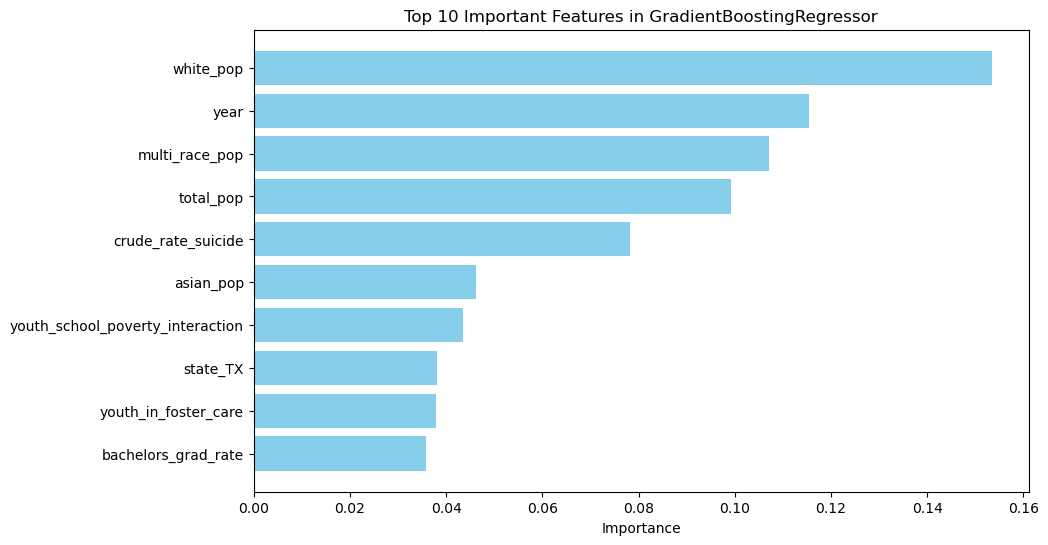

In [10]:
import matplotlib.pyplot as plt

# Plot the top 10 most important features
top_10_features = feature_importance_df.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_10_features['feature'], top_10_features['importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.xlabel("Importance")
plt.title("Top 10 Important Features in GradientBoostingRegressor")



In [11]:
### Hypertune Gradient Boost

In [12]:


# Define the parameter grid for Gradient Boosting
param_grid = {
    'model__n_estimators': [200, 300,400,500],
    'model__max_depth': [3, 4],
    'model__learning_rate': [0.01, 0.05, 0.1,0.2,0.3],
    'model__min_samples_split': [2, 5, 10,15],
    'model__min_samples_leaf': [1, 2, 4],
    'model__subsample': [0.6, 0.8, 1.0]
}

# Setup GridSearchCV with the pipeline and parameter grid
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Best parameters from grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_ 

print("Best Parameters:", best_params)
print("Best Cross-Validated MSE:", best_score)


Fitting 5 folds for each of 1440 candidates, totalling 7200 fits
Best Parameters: {'model__learning_rate': 0.05, 'model__max_depth': 4, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 500, 'model__subsample': 1.0}
Best Cross-Validated MSE: 0.6614001454410519


In [13]:
# Predict on training and testing data
best_model = grid_search.best_estimator_
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)


# Calculate training and testing scores
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
#print("Training Scores:")
#print(f"MSE: {train_mse}, MAE: {train_mae}, R2: {train_r2}")

#print("\nTesting Scores:")
#print(f"MSE: {test_mse}, MAE: {test_mae}, R2: {test_r2}")


#print("\nCross-Validation Scores (averaged across 5 folds):")
#print(f" R2: {np.mean(cv_r2)}")
print("Best Parameters:", best_params)
print("Best Cross-Validated R²:", best_score)
print("Training MSE:", train_mse)
print("Training MAE:", train_mae)
print("Training R²:", train_r2)
print("Testing MSE:", test_mse)
print("Testing MAE:", test_mae)
print("Testing R²:", test_r2)


Best Parameters: {'model__learning_rate': 0.05, 'model__max_depth': 4, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 500, 'model__subsample': 1.0}
Best Cross-Validated R²: 0.6614001454410519
Training MSE: 0.0036880683329335376
Training MAE: 0.04740344232766192
Training R²: 0.9996442003027904
Testing MSE: 2.6019048078551625
Testing MAE: 0.8346889706657769
Testing R²: 0.7195926846133068


###  XG Boosting

In [15]:
# Pipeline setup
pipeline = Pipeline(steps=[
    ('preprocessor', column_transformer),
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(random_state=42))
])


# Training the base model
pipeline.fit(X_train, y_train)

# Making predictions on training and testing sets
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Evaluating the model on training, validation, and testing sets
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train= r2_score(y_train, y_train_pred)


mse_test = mean_squared_error(y_test, y_test_pred)
mae_test= mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)



print("Training MSE:", mse_train)
print("Training MAE:", mae_train)
print("Training R²:", r2_train)
print("Testing MSE:", mse_test)
print("Testing MAE:", mae_test)
print("Testing R²:", r2_test)



Training MSE: 1.018858964207014e-06
Training MAE: 0.000720328973557593
Training R²: 0.999999901707431
Testing MSE: 3.4549934190058367
Testing MAE: 0.8971431270494014
Testing R²: 0.6276553137619444


###  HyperTune XG Boosting

In [17]:


# Define the parameter grid
param_grid = {
    'xgb__n_estimators': [100, 300, 500],            # Number of trees
    'xgb__max_depth': [2, 3, 4],                     # Tree depth
    'xgb__learning_rate': [0.01, 0.05, 0.1],         # Learning rate for step size
    'xgb__reg_lambda': [0.5, 1, 5],                  # L2 regularization
    'xgb__reg_alpha': [0, 0.1, 0.5]                  # L1 regularization
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,                             # 5-fold cross-validation
                    
    n_jobs=-1,                        # Use all available cores
   
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Retrieve best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_

y_train_pred = grid_search.best_estimator_.predict(X_train)
y_test_pred = grid_search.best_estimator_.predict(X_test)
# Evaluate the best model on the test set
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)


print("Best Parameters:", best_params)
print("Best Cross-Validated R²:", best_score)
print("Training MSE:", train_mse)
print("Training MAE:", train_mae)
print("Training R²:", train_r2)
print("Testing MSE:", test_mse)
print("Testing MAE:", test_mae)
print("Testing R²:", test_r2)

Best Parameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 4, 'xgb__n_estimators': 500, 'xgb__reg_alpha': 0.1, 'xgb__reg_lambda': 0.5}
Best Cross-Validated R²: 0.6635061453446551
Training MSE: 0.00036238065794446495
Training MAE: 0.013934094229745057
Training R²: 0.99996503998388
Testing MSE: 2.96297342825194
Testing MAE: 0.8989443491627467
Testing R²: 0.6806803146410565


### SVM

In [19]:


# Define the SVM pipeline with scaling
pipeline = Pipeline([
    ('preprocessor', column_transformer),
    ('scaler', StandardScaler()),       # Scale features for SVR
    ('svr', SVR(C=1.0, epsilon=0.1))    # Basic SVR model with default parameters
])


# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on training and testing sets

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Evaluate the model performance
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2_log = r2_score(y_test, y_test_pred)



print("Training MSE:", train_mse)
print("Training MAE:", train_mae)
print("Training R²:", train_r2)
print("Testing MSE:", test_mse)
print("Testing MAE:", test_mae)
print("Testing R²:", test_r2)


Training MSE: 6.735198353060241
Training MAE: 1.201104250348028
Training R²: 0.350233965768473
Testing MSE: 6.757359948130886
Testing MAE: 1.2449075809744414
Testing R²: 0.6806803146410565


### Hypertune SVM

In [21]:



# Define the parameter grid for GridSearchCV
param_grid = {
    'svr__C': [0.1, 1, 10],              # Regularization strength
    'svr__epsilon': [0.01, 0.1, 0.5],    # Insensitivity margin
    'svr__kernel': ['linear', 'rbf']      # Kernels to test
}

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Retrieve the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Make predictions with the best estimator on the test set
y_train_pred = grid_search.best_estimator_.predict(X_train)
y_test_pred= grid_search.best_estimator_.predict(X_test)

# Evaluate the model on the test set
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Best Parameters:", best_params)
print("Best Cross-Validated R²:", best_score)

print("Training MSE:", train_mse)
print("Training MAE:", train_mae)
print("Training R²:", train_r2)
print("Testing MSE:", test_mse)
print("Testing MAE:", test_mae)
print("Testing R²:", test_r2)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'svr__C': 10, 'svr__epsilon': 0.5, 'svr__kernel': 'rbf'}
Best Cross-Validated R²: 0.4659605141756953
Training MSE: 1.7373871531396496
Training MAE: 0.6832981117999561
Training R²: 0.8323887284021232
Testing MSE: 4.308295404835904
Testing MAE: 1.159617026706718
Testing R²: 0.5356949475185755


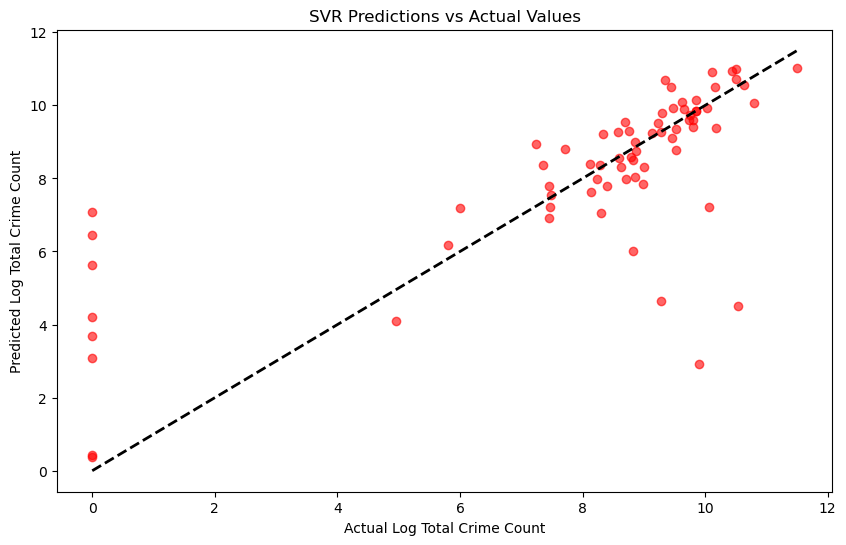

In [22]:
import matplotlib.pyplot as plt

# Plotting predicted vs actual values for the test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6, color='r')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Log Total Crime Count')
plt.ylabel('Predicted Log Total Crime Count')
plt.title('SVR Predictions vs Actual Values')
plt.show()


### Stacking

In [24]:
#stacking
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression,Lasso,Ridge

# Define the base models
base_models = [
    ('gradient_boosting', GradientBoostingRegressor(learning_rate= 0.01, max_depth=4, n_estimators= 500,random_state=42, validation_fraction=0.2, n_iter_no_change=10)),
# Define the meta-modelrandom_state=42)),
    ('random_forest', RandomForestRegressor(random_state=42)),
   ('lasso', Lasso(alpha=0.1, max_iter=10000))
]


meta_model = Ridge(alpha=1.0)

# Create the stacking ensemble
stacked_ensemble = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)
# Create the pipeline with preprocessing and stacking ensemble
stacking_pipeline = Pipeline(steps=[
    ('preprocessor', column_transformer),
    ('scaler', StandardScaler()),
    ('stacked_model', stacked_ensemble)
])


# Fit the stacked model on the training data
stacking_pipeline.fit(X_train, y_train)

# Evaluate the stacked model on the test data
y_train_pred = stacking_pipeline.predict(X_train)
y_test_pred= stacking_pipeline.predict(X_test)

ensemble_train_score = stacking_pipeline.score(X_train, y_train)
ensemble_test_score = stacking_pipeline.score(X_test, y_test)

# Evaluate the model on the test set
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)


print("Training MSE:", train_mse)
print("Training MAE:", train_mae)
print("Training R²:", train_r2)
print("Testing MSE:", test_mse)
print("Testing MAE:", test_mae)
print("Testing R²:", test_r2)

Training MSE: 0.3555821110552533
Training MAE: 0.4376881139489744
Training R²: 0.9656958613491958
Testing MSE: 2.555043011370487
Testing MAE: 0.9271929434085542
Testing R²: 0.724642981037217


### Stacking with best Parameters]

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

# Define base models and meta model
base_models = [
    ('gradient_boosting', GradientBoostingRegressor(learning_rate=0.05, max_depth=4, n_estimators=500, random_state=42,min_samples_leaf= 1,min_samples_split= 5)),
    ('random_forest', RandomForestRegressor(ccp_alpha=0.1,n_estimators=50, max_depth=7,random_state=42,min_samples_leaf= 4,min_samples_split= 8)),
   ('lasso', Lasso(alpha=0.1, max_iter=10000))
]


meta_model = Ridge(alpha=1.0)


# Define the stacking regressor
stacked_ensemble = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)

# Create pipeline with stacking ensemble
stacking_pipeline = Pipeline(steps=[
    ('preprocessor', column_transformer),
    ('scaler', StandardScaler()),
    ('stacked_model', stacked_ensemble)
])

# Fit GridSearchCV on the training data to find the best parameters
stacking_pipeline.fit(X_train, y_train)


# Evaluate the stacked model on the test data
y_train_pred = stacking_pipeline.predict(X_train)
y_test_pred= stacking_pipeline.predict(X_test)

ensemble_train_score = stacking_pipeline.score(X_train, y_train)
ensemble_test_score = stacking_pipeline.score(X_test, y_test)

# Evaluate the model on the test set
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)


print("Training MSE:", train_mse)
print("Training MAE:", train_mae)
print("Training R²:", train_r2)
print("Testing MSE:", test_mse)
print("Testing MAE:", test_mae)
print("Testing R²:", test_r2)

Training MSE: 0.044112777714493775
Training MAE: 0.16902213109461456
Training R²: 0.9957442998510266
Testing MSE: 2.516389534410761
Testing MAE: 0.8753803089778681
Testing R²: 0.728808666757892


### Multi Target Regressor 

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
# Define features and target
features_to_exclude_revised = [
    'crimes_against_society', 'fraud_and_other_financial_crimes', 
    'property_crime', 'violent_crime' # Excluding the target
]
X = data.drop(columns=features_to_exclude_revised)
y =np.log1p(data[features_to_exclude_revised]) 

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Column transformer for preprocessing
column_transformer = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(), ['year']),  # Ordinal encoding for 'year'
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), ['state'])  # One-hot for 'state'
    ],
    remainder='passthrough'  # Keep other columns as they are
)


# Define the base model and MultiOutputRegressor
base_model = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)
multi_target_regressor = MultiOutputRegressor(base_model)

# Create a pipeline that combines the preprocessing with the model
# Update the pipeline with scaling
pipeline = Pipeline(steps=[
    ('preprocessor', column_transformer),
    ('scaler', StandardScaler()),  # Add a scaler to normalize features
    ('regressor', multi_target_regressor)
])
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
r2 = r2_score(y_test, y_pred, multioutput='raw_values')

print("Mean Squared Error for each target:", mse)
print("Mean Absolute Error for each target:", mae)
print("R^2 Score for each target:", r2)


Mean Squared Error for each target: [0.04318978 0.1254456  0.0377176  0.04379996]
Mean Absolute Error for each target: [0.15783822 0.23630305 0.13833504 0.14654926]
R^2 Score for each target: [0.99382096 0.97379248 0.99499884 0.99426591]
